In [2]:
import re
import os
import sys
import cv2
import struct
import imageio
import numpy as np
from PIL import Image
from glob import glob
from os.path import join
from pathlib import Path
import matplotlib.pyplot as plt


def read_pfm(filename):
    file = open(filename, 'rb')
    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().decode('utf-8').rstrip()
    if header == 'PF':
        color = True
    elif header == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode('utf-8'))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().rstrip())
    if scale < 0:  # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>'  # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    file.close()
    return data, scale


# read an image
def read_img(filename):
    img = Image.open(filename)
    # scale 0~255 to 0~1
    np_img = np.array(img, dtype=np.float32) / 255.
    return np_img


# read a binary mask
def read_mask(filename):
    return read_img(filename) > 0.5


# save a binary mask
def save_mask(filename, mask):
    assert mask.dtype == np.bool
    mask = mask.astype(np.uint8) * 255
    Image.fromarray(mask).save(filename)


# read a pair file, [(ref_view1, [src_view1-1, ...]), (ref_view2, [src_view2-1, ...]), ...]
def read_pair_file(filename):
    data = []
    with open(filename) as f:
        num_viewpoint = int(f.readline())
        # 49 viewpoints
        for view_idx in range(num_viewpoint):
            ref_view = int(f.readline().rstrip())
            src_views = [int(x) for x in f.readline().rstrip().split()[1::2]]
            if len(src_views) > 0:
                data.append((ref_view, src_views))
    return data

# torch.no_grad warpper for functions
def make_nograd_func(func):
    def wrapper(*f_args, **f_kwargs):
        with torch.no_grad():
            ret = func(*f_args, **f_kwargs)
        return ret

    return wrapper


# convert a function into recursive style to handle nested dict/list/tuple variables
def make_recursive_func(func):
    def wrapper(vars):
        if isinstance(vars, list):
            return [wrapper(x) for x in vars]
        elif isinstance(vars, tuple):
            return tuple([wrapper(x) for x in vars])
        elif isinstance(vars, dict):
            return {k: wrapper(v) for k, v in vars.items()}
        else:
            return func(vars)

    return wrapper

# a wrapper to compute metrics for each image individually
def compute_metrics_for_each_image(metric_func):
    def wrapper(depth_est, depth_gt, mask, *args):
        batch_size = depth_gt.shape[0]
        results = []
        # compute result one by one
        for idx in range(batch_size):
            ret = metric_func(depth_est[idx], depth_gt[idx], mask[idx], *args)
            results.append(ret)
        return torch.stack(results).mean()

    return wrapper

def mean_relative_absolute_error(y_true, y_pred):
    """
    Compute the mean relative absolute error (MRAE) between two numpy arrays.

    Parameters:
    y_true (numpy.array): The ground truth values.
    y_pred (numpy.array): The predicted values.

    Returns:
    float: The MRAE metric result.
    """
    # Avoid division by zero
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    
    # Calculate MRAE
    mrae = np.mean(np.abs((y_true - y_pred) / y_true))
    
    return mrae

#### COLMAP Utils

In [3]:
#!/usr/bin/env python

# Copyright (c) 2023, ETH Zurich and UNC Chapel Hill.
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
#     * Redistributions of source code must retain the above copyright
#       notice, this list of conditions and the following disclaimer.
#
#     * Redistributions in binary form must reproduce the above copyright
#       notice, this list of conditions and the following disclaimer in the
#       documentation and/or other materials provided with the distribution.
#
#     * Neither the name of ETH Zurich and UNC Chapel Hill nor the names of
#       its contributors may be used to endorse or promote products derived
#       from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDERS OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.


def read_array(path):
    with open(path, "rb") as fid:
        width, height, channels = np.genfromtxt(
            fid, delimiter="&", max_rows=1, usecols=(0, 1, 2), dtype=int
        )
        fid.seek(0)
        num_delimiter = 0
        byte = fid.read(1)
        while True:
            if byte == b"&":
                num_delimiter += 1
                if num_delimiter >= 3:
                    break
            byte = fid.read(1)
        array = np.fromfile(fid, np.float32)
    array = array.reshape((width, height, channels), order="F")
    return np.transpose(array, (1, 0, 2)).squeeze()


def write_array(array, path):
    """
    see: src/mvs/mat.h
        void Mat<T>::Write(const std::string& path)
    """
    assert array.dtype == np.float32
    if len(array.shape) == 2:
        height, width = array.shape
        channels = 1
    elif len(array.shape) == 3:
        height, width, channels = array.shape
    else:
        assert False

    with open(path, "w") as fid:
        fid.write(str(width) + "&" + str(height) + "&" + str(channels) + "&")

    with open(path, "ab") as fid:
        if len(array.shape) == 2:
            array_trans = np.transpose(array, (1, 0))
        elif len(array.shape) == 3:
            array_trans = np.transpose(array, (1, 0, 2))
        else:
            assert False
        data_1d = array_trans.reshape(-1, order="F")
        data_list = data_1d.tolist()
        endian_character = "<"
        format_char_sequence = "".join(["f"] * len(data_list))
        byte_data = struct.pack(
            endian_character + format_char_sequence, *data_list
        )
        fid.write(byte_data)

#### MVSNet Utils

In [4]:
def load_pfm(file):
    color = None
    width = None
    height = None
    scale = None
    data_type = None
    header = file.readline().decode('UTF-8').rstrip()

    if header == 'PF':
        color = True
    elif header == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')
    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode('UTF-8'))
    if dim_match:
        width, height = map(int, dim_match.groups())
    else:
        raise Exception('Malformed PFM header.')
    # scale = float(file.readline().rstrip())
    scale = float((file.readline()).decode('UTF-8').rstrip())
    if scale < 0: # little-endian
        data_type = '<f'
    else:
        data_type = '>f' # big-endian
    data_string = file.read()
    data = np.fromstring(data_string, data_type)
    shape = (height, width, 3) if color else (height, width)
    data = np.reshape(data, shape)
    data = cv2.flip(data, 0)
    return data

## Save predicted and Ground-Truth DepthMaps

In [5]:
# GT_DEPTHS_DIR = "/Users/umairkhawaja/Desktop/workspace/TUM/W23/AD4CV/Depths"
# PRED_DEPTHS_DIR = "casmvsnet_outputs/"

In [6]:
# all_maes = []
# for scene_dir in glob(PRED_DEPTHS_DIR + "/*"):
#     if not scene_dir.endswith(".ply"):
#         scene_name = scene_dir.split("/")[-1]
#         scene_dmap_dir = join(scene_dir, "depth_est")
#         scene_mask_dir = join(scene_dir, "mask")

#         scene_metrics = []
#         for pred_dmap_path in glob(scene_dmap_dir + "/*"):
#             try:
#                 filename = pred_dmap_path.split("/")[-1]
#                 pred_mask_path = join(scene_mask_dir, filename.replace(".pfm", "_final.png"))
                
#                 pfm_num = int(filename.split(".")[0])
#                 zero_pad = "000" if pfm_num < 10 else "00"
                
#                 gt_dmap_path = join(GT_DEPTHS_DIR, scene_name, f"depth_map_{zero_pad}{pfm_num}.pfm")
#                 gt_mask_path = join(GT_DEPTHS_DIR, scene_name, f"depth_visual_{zero_pad}{pfm_num}.png")

#                 pred_dmap, pred_scale = read_pfm(pred_dmap_path)
#                 gt_dmap, gt_scale = read_pfm(gt_dmap_path)
#                 gt_mask = read_mask(gt_mask_path)
#                 pred_mask = read_mask(pred_mask_path)

#                 gt_dmap = gt_dmap * gt_mask
#                 pred_dmap = pred_dmap * pred_mask

#                 pred_dmap = pred_dmap.astype(np.float32)
#                 pred_dmap = cv2.resize(pred_dmap, (gt_mask.shape[1], gt_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

#                 # Create a figure and a set of subplots
#                 fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

#                 # Display Ground truth depth map
#                 im1 = ax1.imshow(gt_dmap, cmap='plasma')
#                 ax1.set_title('Ground Truth Depth Map')
#                 fig.colorbar(im1, ax=ax1)  # Add colorbar for reference

#                 # Display Predicted depth map
#                 im2 = ax2.imshow(pred_dmap, cmap='plasma')
#                 ax2.set_title('Predicted Depth Map')
#                 fig.colorbar(im2, ax=ax2)  # Add colorbar for reference


#                 pred_dmap_gt_mask = pred_dmap * gt_mask
#                 im3 = ax3.imshow(pred_dmap_gt_mask, cmap='plasma')
#                 ax3.set_title('Predicted Depth Map with GT Mask')
#                 fig.colorbar(im3, ax=ax3)  # Add colorbar for reference


#                 mae = np.mean(np.abs(pred_dmap_gt_mask - gt_dmap))
#                 mrae = mean_relative_absolute_error(gt_dmap, pred_dmap_gt_mask)

#                 plt.suptitle(f"Error with GT Masking:  MAE {mae:.3f} | MRAE {mrae:.3f}")
                
#                 # Save the figure to a JPG file
#                 plot_dir = f"{PRED_DEPTHS_DIR}/plots/{scene_name}/"
#                 Path(plot_dir).mkdir(parents=True, exist_ok=True)
#                 fig.savefig(f"{plot_dir}/{filename.replace('.pfm', '.jpg')}")
#                 plt.close('all')
#                 scene_metrics.append(mae)
#             except FileNotFoundError as e:
#                 print(f"[MISSING DATA] {e.filename}")
#         scene_error = np.mean(scene_metrics)
#         all_maes.append(scene_error)

In [7]:
# !ls 

## COLMAP

Text(0.5, 1.0, 'depth map')

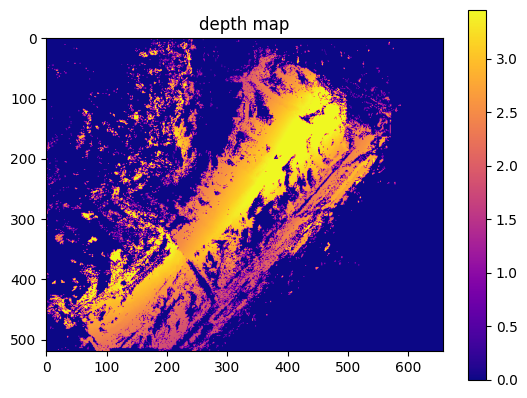

In [13]:
binary_depth_map_path = "/home/dataset/mvs_training/dtu/Rectified/scan100_train/colmap_output/dense/0/stereo/depth_maps/00000000.jpg.geometric.bin"
depth_map = read_array(binary_depth_map_path)
min_depth_percentile = 5
max_depth_percentile = 95
min_depth, max_depth = np.percentile(
        depth_map, [min_depth_percentile, max_depth_percentile]
    )
depth_map[depth_map < min_depth] = min_depth
depth_map[depth_map > max_depth] = max_depth

import pylab as plt

# Visualize the depth map.
fig = plt.figure()
im = plt.imshow(depth_map, cmap='plasma')
fig.colorbar(im)
plt.title("depth map")

## MVSNet Predictions

/tmp/ipykernel_4171131/3661749520.py:27: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(data_string, data_type)


value range:  425.00003 679.0


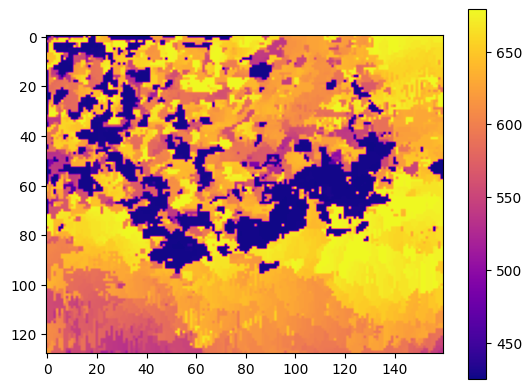

In [17]:
import matplotlib.pyplot as plt
depth_path = "/home/dataset/mvs_training/dtu/Rectified/scan100_train/mvsnet_output/00000000_init.pfm"
prob_path = "/home/dataset/mvs_training/dtu/Rectified/scan100_train/mvsnet_output/00000000_prob.pfm"
depth_image = load_pfm(open(depth_path, 'rb'))
prob_image = load_pfm(open(prob_path, 'rb'))
filter_mask = (prob_image > 0.0).astype(np.uint8)
depth_image *= filter_mask
ma = np.ma.masked_equal(depth_image, 0.0, copy=False)
print('value range: ', ma.min(), ma.max())
im = plt.imshow(depth_image, cmap='plasma')
fig.colorbar(im)
plt.show()

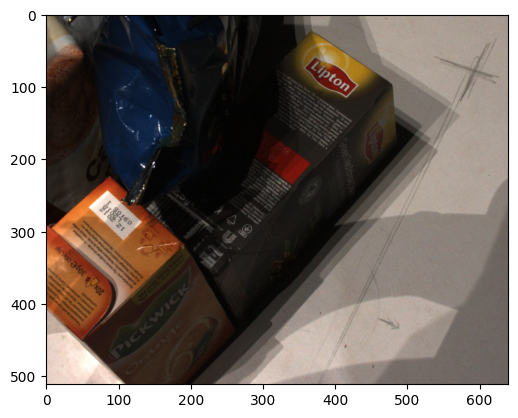

In [19]:
plt.imshow(plt.imread("/home/dataset/mvs_training/dtu/Rectified/scan100_train/images/00000000.jpg"))

Text(0.5, 1.0, 'depth map')

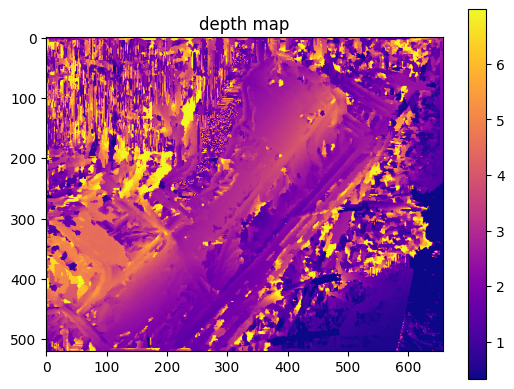

In [20]:
depth_map = read_array("/home/dataset/mvs_training/dtu/Rectified/scan100_train/colmap_output/dense/0/stereo/depth_maps/00000000.jpg.photometric.bin")
min_depth_percentile = 5
max_depth_percentile = 95
min_depth, max_depth = np.percentile(
        depth_map, [min_depth_percentile, max_depth_percentile]
    )
depth_map[depth_map < min_depth] = min_depth
depth_map[depth_map > max_depth] = max_depth

import pylab as plt

# Visualize the depth map.
fig = plt.figure()
im = plt.imshow(depth_map, "plasma")
plt.colorbar(im)
plt.title("depth map")

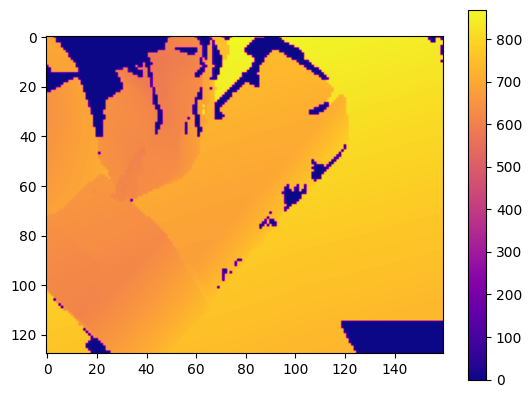

In [21]:
dmap, _ = read_pfm("/home/dataset/mvs_training/dtu/Depths_raw/scan100_train/depth_map_0000.pfm")
fig = plt.figure()
im = plt.imshow(dmap, 'plasma')
plt.colorbar(im)
plt.show()